# EhV: clustering

In this notebook, we perform a clustering analysis of the EhV data on features extracted from SCIP.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from sklearn.feature_selection import VarianceThreshold
import anndata
import scanpy
scanpy.settings.verbosity = 3

In [4]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [96]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)

df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]

df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(103775, 914)

In [97]:
cols = [c for c in pandas.read_feather(data_dir / "cells_scaled.feather").columns if c not in ["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"]]
feat_cols = [c for c in cols if c.startswith("feat")]

In [98]:
df = df.loc[numpy.load(data_dir / "indices/cluster_index.npy", allow_pickle=True)]

In [99]:
df.shape

(41876, 914)

In [100]:
adata = anndata.AnnData(df.filter(regex="feat").fillna(0).astype(numpy.float32))
for col in df.filter(regex='meta'):
    adata.obs[col] = df[col]

In [101]:
scanpy.pp.scale(adata)

In [102]:
adata_rfe = adata[:, feat_cols].copy()

In [103]:
def louvain_clustering(adata):
    scanpy.tl.pca(adata, svd_solver='arpack')
    scanpy.pp.neighbors(adata, n_neighbors=30)
    scanpy.tl.louvain(adata)
    scanpy.tl.paga(adata)

In [104]:
%%time
louvain_clustering(adata)

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:21)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
CPU times: user 42.2 s, sys: 390 ms, total: 42.6 s
Wall time: 42.8 s


--> added 'pos', the PAGA positions (adata.uns['paga'])


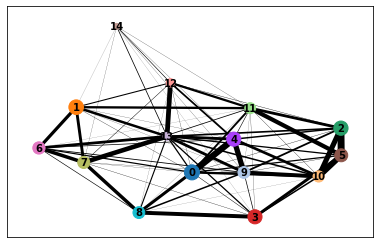

In [107]:
scanpy.pl.paga(adata)

In [108]:
scanpy.tl.umap(adata, min_dist=0.1, init_pos="paga")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [109]:
markers = [col for col in adata.var.index if col.startswith("feat_sum")]

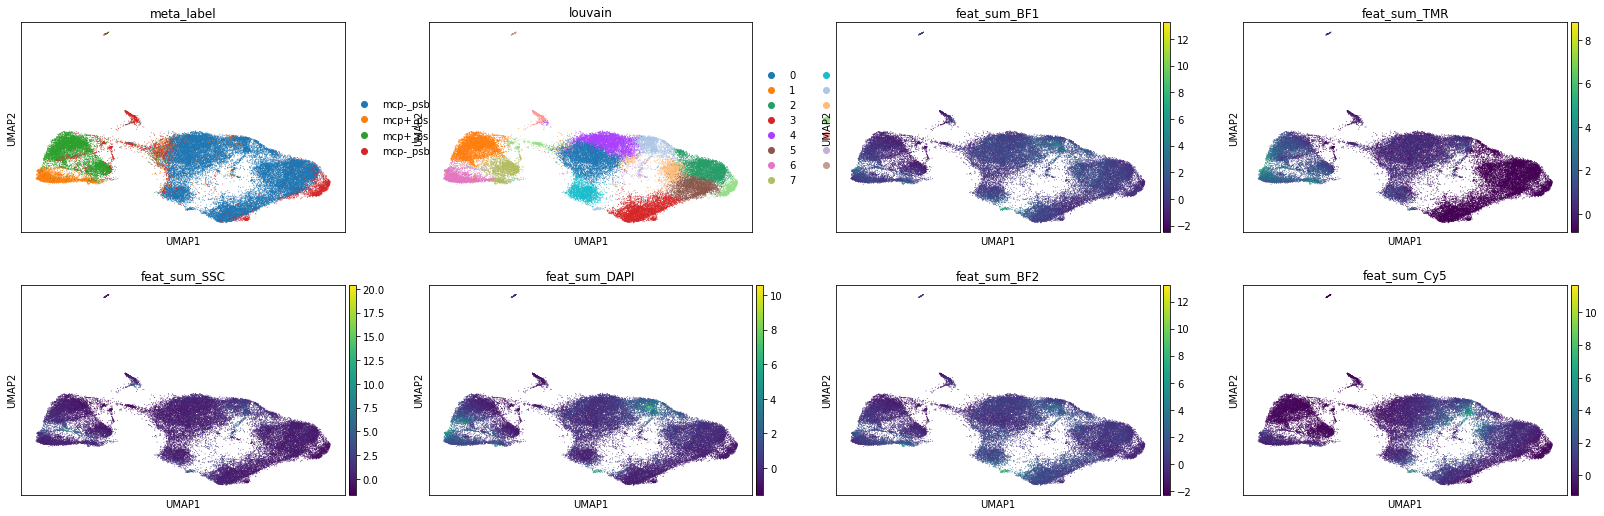

In [110]:
scanpy.pl.umap(adata, color=["meta_label", "louvain"] + markers)

<AxesSubplot:xlabel='louvain', ylabel='count'>

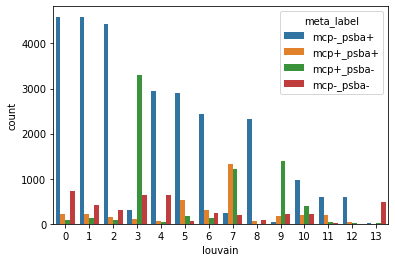

In [ ]:
seaborn.countplot(data=adata.obs, x="louvain", hue="meta_label")

In [105]:
%%time
louvain_clustering(adata_rfe)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:25)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)
CPU times: user 43 s, sys: 307 ms, total: 43.3 s
Wall time: 43.5 s


--> added 'pos', the PAGA positions (adata.uns['paga'])


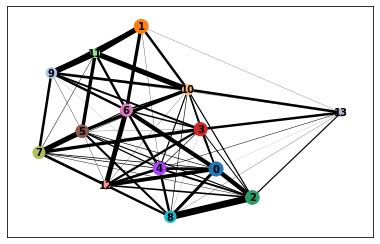

In [112]:
scanpy.pl.paga(adata_rfe)

In [113]:
scanpy.tl.umap(adata_rfe, min_dist=0.1, init_pos="paga")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [114]:
markers = [col for col in adata_rfe.var.index if col.startswith("feat_sum")]

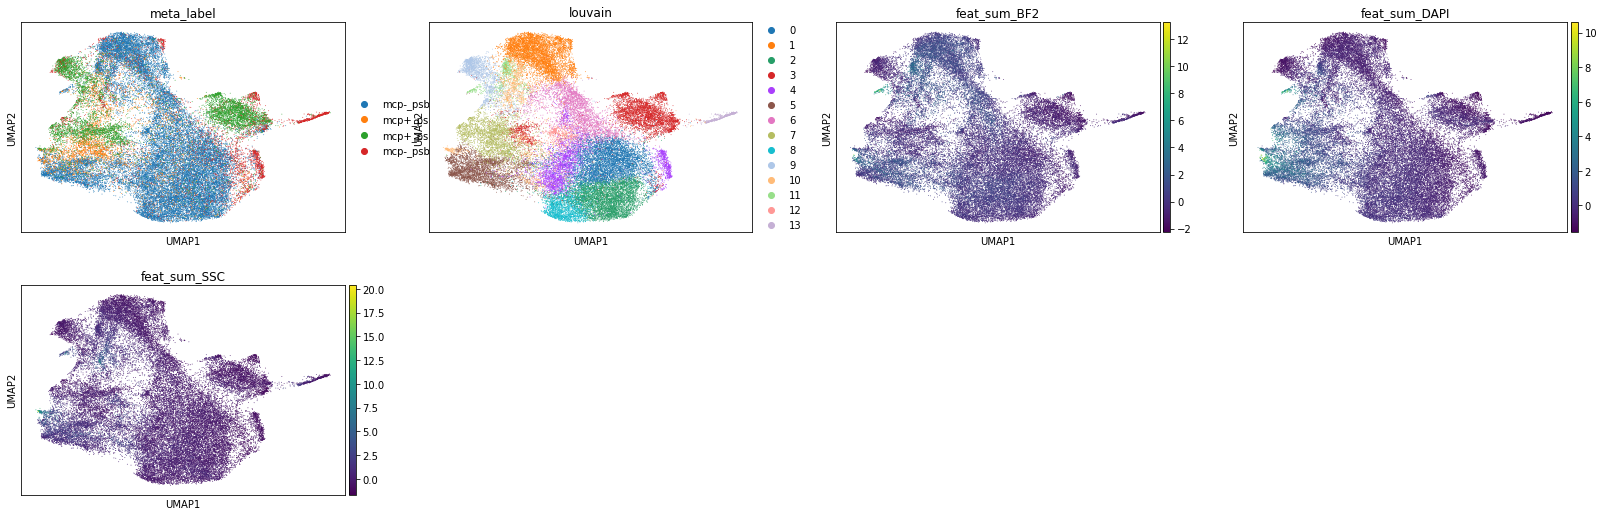

In [115]:
scanpy.pl.umap(adata_rfe, color=["meta_label", "louvain"] + markers)

<AxesSubplot:xlabel='louvain', ylabel='count'>

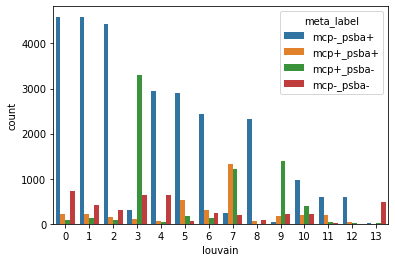

In [116]:
seaborn.countplot(data=adata_rfe.obs, x="louvain", hue="meta_label")